# YOLO Fine-Tuning su LineMOD

Versione minimale e pulita del processo di fine-tuning YOLO su LineMOD:
1. Caricamento modello YOLO pre-addestrato
2. Preparazione dataset
3. Fine-tuning della head
4. Valutazione su test set


## 1. Import e setup

In [1]:
# 1. Import e setup
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.yolo_detector import YOLODetector
from utils.prepare_yolo_symlinks import prepare_yolo_dataset_symlinks, create_data_yaml
from utils.organize_yolo_results import organize_yolo_output, print_organization_summary


Cache Strategy: full


## 2. Carica modello YOLO e prepara dataset

In [2]:
# 2. Carica modello YOLO e prepara dataset

detector = YOLODetector(
    model_name=Config.YOLO_MODEL,  # usa modello pre-addestrato
    pretrained=True,
    num_classes=Config.NUM_CLASSES
)

# Prepara dataset (symlinks e data.yaml)
output_dir = Config.LINEMOD_ROOT / 'yolo_symlinks'
if (output_dir / 'data.yaml').exists():
    data_yaml_path = output_dir / 'data.yaml'
else:
    prepare_yolo_dataset_symlinks(
        dataset_root=Config.LINEMOD_ROOT,
        output_root=output_dir,
        use_symlinks=True
    )
    data_yaml_path = create_data_yaml(output_dir, Config.DATASETS_DIR)
print(f"Dataset pronto: {data_yaml_path}")

✅ Loading pretrained yolo11n from cache: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pretrained/yolo11n.pt
⚠️  COCO pretrained weights have 80 classes, but you have 13 classes
🔄 Modifying detection head...

🔍 Inspecting cv3 structure:
   cv3[0]: Sequential
   Structure: Sequential(
  (0): Sequential(
    (0): DWConv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
  )
  (1): Sequential(
    (0): DWConv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80, bias=False)
      (bn): BatchNorm2d(80, eps=0.00

## 3. Fine-tuning solo della head

In [3]:
# 3. Fine-tuning solo della head
# Definizione path e nomi usati più volte
run_dir = Config.CHECKPOINT_DIR / 'yolo' / f'yolo_train{Config.YOLO_EPOCHS}'
data_yaml_path = str(data_yaml_path)  # già definito sopra, ma lo forziamo a stringa per sicurezza
runs_val_dir = Path('runs/detect/val')  # directory temporanea YOLO

# Congela backbone, allena solo la head
detector.freeze_backbone(freeze_until_layer=Config.YOLO_FREEZE_UNTIL_LAYER)

results = detector.train(
    data_yaml=data_yaml_path,
    epochs=Config.YOLO_EPOCHS,
    imgsz=Config.YOLO_IMG_SIZE,
    batch_size=Config.YOLO_BATCH_SIZE,
    project=str(Config.CHECKPOINT_DIR / 'yolo'),
    name=f'yolo_train{Config.YOLO_EPOCHS}',
    save=True,
    cache=True,
    amp=Config.AMP_YOLO,
    workers=Config.NUM_WORKERS,
    verbose=True
)
print("Training completato.")

# Organizza automaticamente i risultati in sottocartelle
stats = organize_yolo_output(run_dir=runs_val_dir, destination_dir=run_dir)
print_organization_summary(run_dir, stats)


🔒 Freezing backbone until layer 10...

📊 Parameter Statistics:
   Total: 2,546,935
   Frozen: 1,115,744 (43.8%)
   Trainable: 1,431,191 (56.2%)

✅ Backbone frozen! Only detection head will be trained.

🚂 Starting YOLO training...
   Model: yolo11n
   Epochs: 5
   Image size: 416
   Batch size: 32
   LR (initial → final): 0.01 → 0.0001
   Optimizer: SGD
   Device: mps

New https://pypi.org/project/ultralytics/8.3.241 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.13.3 torch-2.9.1 MPS (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=F

## 4. Valutazione su test set

In [4]:
# 4. Valutazione su test set
YOLO_NAME = f'yolo_train{Config.YOLO_EPOCHS}'
weights_path = Config.CHECKPOINT_DIR / 'yolo' / YOLO_NAME / 'weights' / 'best.pt'

if weights_path.exists():
    finetuned_detector = YOLODetector(model_name=str(weights_path), num_classes=Config.NUM_CLASSES)
    metrics = finetuned_detector.validate(
        data_yaml=str(data_yaml_path),
        conf=Config.YOLO_CONF_THRESHOLD,
        verbose=False
    )
    print(f"mAP@0.5: {metrics.box.map50:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
else:
    print(f"Modello non trovato: {weights_path}")

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train5/weights/best.pt

📊 Validating YOLO model...
Ultralytics 8.3.234 🚀 Python-3.13.3 torch-2.9.1 MPS (Apple M4 Pro)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1361.8±263.7 MB/s, size: 442.3 KB)
val: Scanning /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/labels/val.cache... 13407 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13407/13407 45.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 419/419 2.2it/s 3:10<0.4s
                   all      13407      21218      0.987      0.971      0.982      0.814
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /Users/nicolotermine/zMe

## 5. Visualizzazione: predizione vs ground truth su immagine casuale

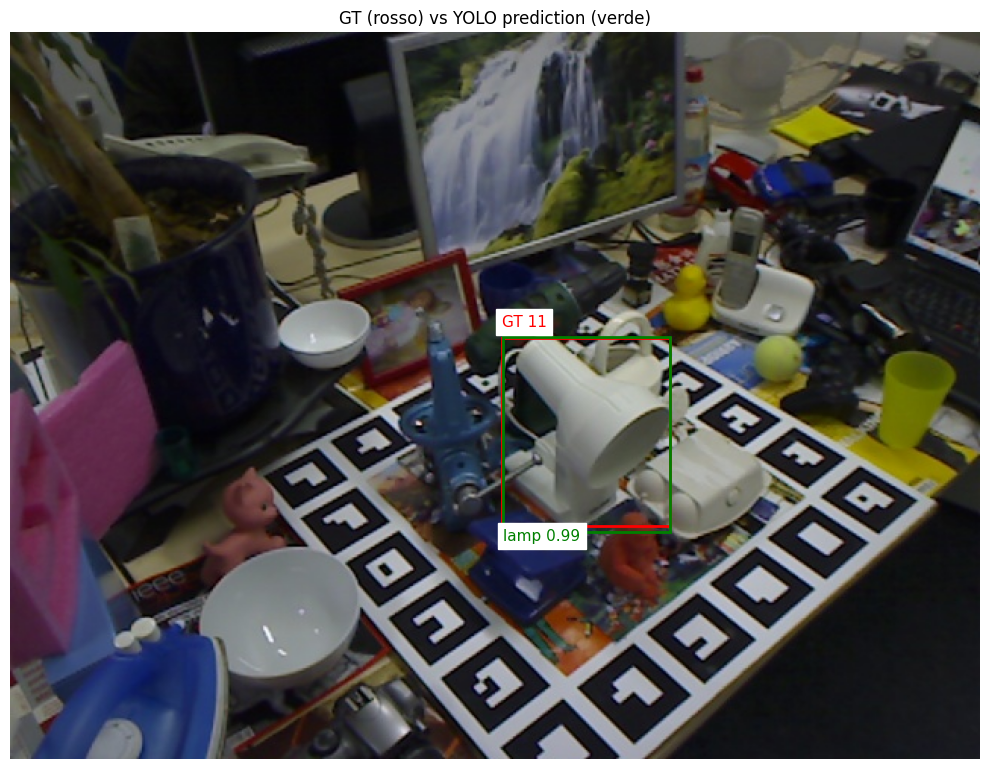

In [ ]:
# %matplotlib inline serve per visualizzare i grafici direttamente all'interno delle celle del notebook,
# rendendo immediata la visualizzazione delle immagini e delle figure prodotte da matplotlib.
%matplotlib inline

# 5. Visualizzazione: predizione vs ground truth su immagine casuale
images_dir = Config.LINEMOD_ROOT / 'yolo_symlinks' / 'images' / 'val'
labels_dir = Config.LINEMOD_ROOT / 'yolo_symlinks' / 'labels' / 'val'

image_files = sorted([p for p in images_dir.iterdir() if p.is_file()])
img_path = random.choice(image_files)
label_path = labels_dir / (img_path.stem + '.txt')

# Carica immagine
pil_img_RGB = np.array(Image.open(img_path).convert('RGB'))
pil_img_BGR = pil_img_RGB[..., ::-1]
H, W = pil_img_RGB.shape[:2]

# Predizione YOLO
if 'finetuned_detector' not in globals():
    finetuned_detector = YOLODetector(model_name=str(weights_path), num_classes=Config.NUM_CLASSES)
detections = finetuned_detector.detect_objects(pil_img_BGR, conf_threshold=0.2)

# Visualizza GT (rosso) e predizioni (verde)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(pil_img_RGB)

# GT: file label YOLO-format: class x_center y_center w h (normalized)
if label_path.exists():
    with open(label_path) as f:
        for line in f:
            if not line.strip():
                continue
            cls, xc, yc, wn, hn = line.split()
            xc, yc, wn, hn = map(float, (xc, yc, wn, hn))
            x0 = (xc - wn/2) * W
            y0 = (yc - hn/2) * H
            x1 = (xc + wn/2) * W
            y1 = (yc + hn/2) * H
            rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x0, y0-8, f'GT {int(cls)}', color='red', fontsize=11, backgroundcolor='white')
else:
    print('GT label file non trovato:', label_path)

# Predizioni YOLO (verde)
for det in detections:
    if 'xyxy' in det:
        x0, y0, x1, y1 = det['xyxy']
    elif 'bbox' in det:
        x0, y0, x1, y1 = det['bbox']
    else:
        continue
    name = det.get('class_name', det.get('class', '?'))
    conf = det.get('confidence', det.get('score', 0))
    rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='green', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.text(x0, y1+6, f'{name} {conf:.2f}', color='green', fontsize=11, backgroundcolor='white')

ax.set_axis_off()
plt.title('GT (rosso) vs YOLO prediction (verde)')
plt.tight_layout()
plt.show()